## Step 3: Training & Prediction

In [1]:
%store -r df_aggregated

In [2]:
import pandas as pd

df = df_aggregated
df = df.reset_index(drop=True)

### Conversion of Columns

In [3]:
from sklearn.preprocessing import OneHotEncoder

# Function to one-hot encode a column
def one_hot_encode(df, column):
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(df[[column]])
    encoded_df = pd.DataFrame(encoded, index=df.index)
    encoded_df.columns = [f'{column}_{i}' for i in range(encoded.shape[1])]
    return encoded_df

# Convert Datetime to pandas datetime object and set as index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

df['Holiday'] = df['Holiday'].astype(int)

# Drop the unnecessary columns
df.drop(['Hour_Category', 'Weekday'], axis=1, inplace=True)

df['DayOfWeek'] = df.index.dayofweek

# One-hot encode 'Hour_Category' and 'Holiday' columns and concatenate with the original dataframe
df = pd.concat([
    df,
    one_hot_encode(df, 'Holiday')
], axis=1)

# Drop the unnecessary columns
df.drop(['Holiday'], axis=1, inplace=True)

print(df)

                     Hour  Cluster  TotalPickups  Month  IsWeekend  DayOfWeek  \
Datetime                                                                        
2014-04-01 00:00:00     0        0            12      4          0          1   
2014-04-01 00:00:00     0        1             7      4          0          1   
2014-04-01 00:00:00     0        2             6      4          0          1   
2014-04-01 00:00:00     0        3             0      4          0          1   
2014-04-01 00:00:00     0        4             1      4          0          1   
...                   ...      ...           ...    ...        ...        ...   
2014-09-30 23:00:00    23        5             0      9          0          1   
2014-09-30 23:00:00    23        6             0      9          0          1   
2014-09-30 23:00:00    23        7             0      9          0          1   
2014-09-30 23:00:00    23        8             0      9          0          1   
2014-09-30 23:00:00    23   

### Creation of October Data

In [4]:
import holidays

# Using US holidays for 2014
us_holidays = holidays.US(years=2014)
holidays_list = list(us_holidays.keys())

# Define the range of dates for October 2014
october_dates = pd.date_range(start='2014-10-01', end='2014-10-31 23:00:00', freq='H')

# Create a DataFrame for each cluster
october_dfs = []
for cluster in range(10):
    df_october = pd.DataFrame(index=october_dates)
    df_october['Cluster'] = cluster
    df_october['Hour'] = df_october.index.hour
    df_october['Month'] = df_october.index.month
    df_october['IsWeekend'] = (df_october.index.dayofweek >= 5).astype(int)
    df_october['DayOfWeek'] = df_october.index.dayofweek
    df_october['Holiday'] = df_october.index.isin(holidays_list).astype(int)
    df_october['TotalPickups'] = 0
    
    october_dfs.append(df_october)
    
# Concatenate all DataFrames to create a final dataset
df_october = pd.concat(october_dfs)

# One-hot encode 'Hour_Category' and 'Holiday' columns and concatenate with the original dataframe
df_october = pd.concat([
    df_october,
    one_hot_encode(df_october, 'Holiday')
], axis=1)

# Drop the unnecessary columns
df_october.drop(['Holiday'], axis=1, inplace=True)

print(df_october)

                     Cluster  Hour  Month  IsWeekend  DayOfWeek  TotalPickups  \
2014-10-01 00:00:00        0     0     10          0          2             0   
2014-10-01 01:00:00        0     1     10          0          2             0   
2014-10-01 02:00:00        0     2     10          0          2             0   
2014-10-01 03:00:00        0     3     10          0          2             0   
2014-10-01 04:00:00        0     4     10          0          2             0   
...                      ...   ...    ...        ...        ...           ...   
2014-10-31 19:00:00        9    19     10          0          4             0   
2014-10-31 20:00:00        9    20     10          0          4             0   
2014-10-31 21:00:00        9    21     10          0          4             0   
2014-10-31 22:00:00        9    22     10          0          4             0   
2014-10-31 23:00:00        9    23     10          0          4             0   

                     Holida

### XGBOOST Training

Processing cluster 0...
Cluster 0: Best number of lags: 2 with MAE: 27.138514125347136


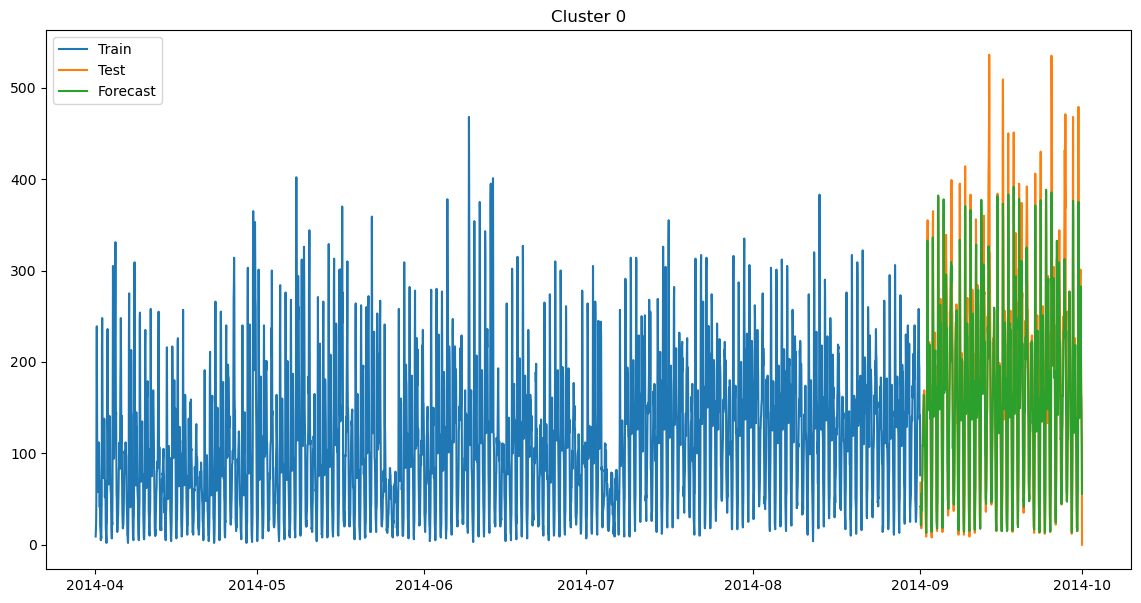

Processing cluster 1...
Cluster 1: Best number of lags: 42 with MAE: 9.534568384289742


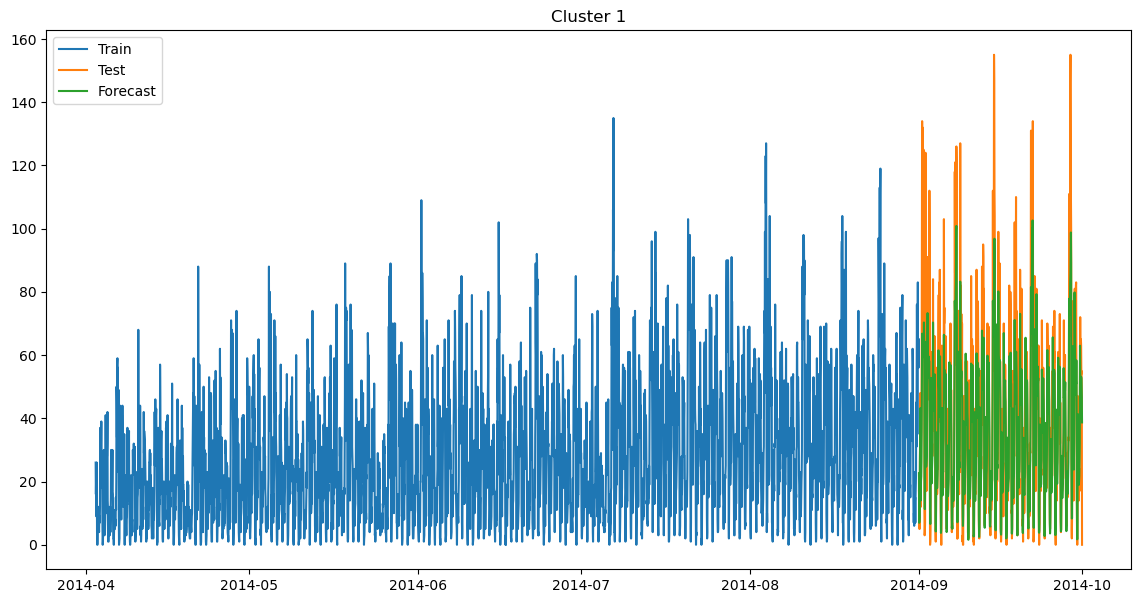

Processing cluster 2...
Cluster 2: Best number of lags: 1 with MAE: 14.180806782510546


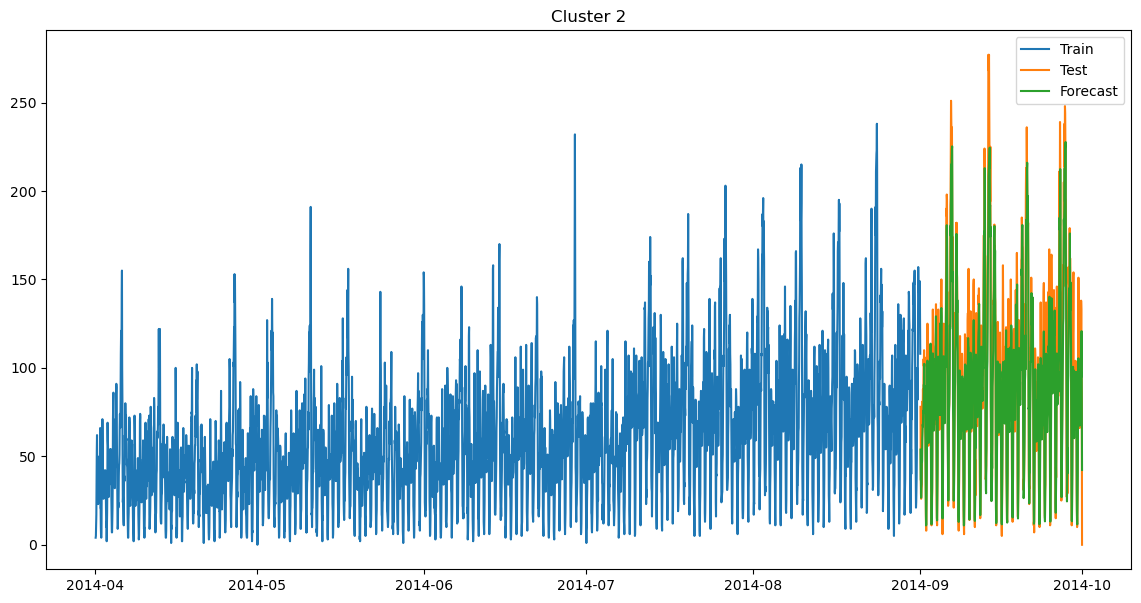

Processing cluster 3...
Cluster 3: Best number of lags: 6 with MAE: 4.092616447475222


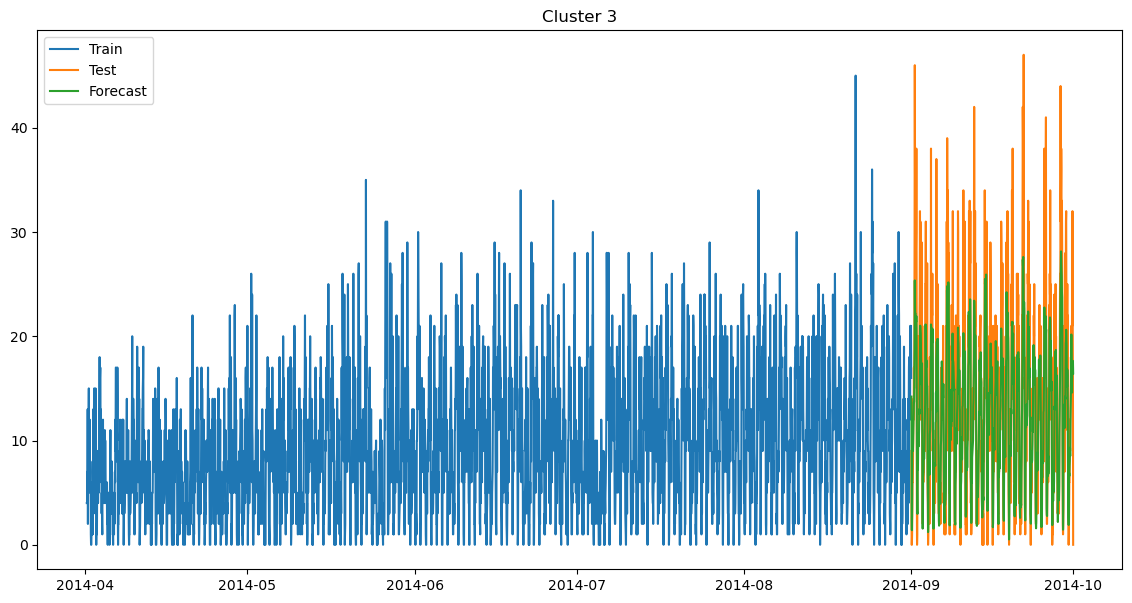

Processing cluster 4...
Cluster 4: Best number of lags: 3 with MAE: 10.383386495378282


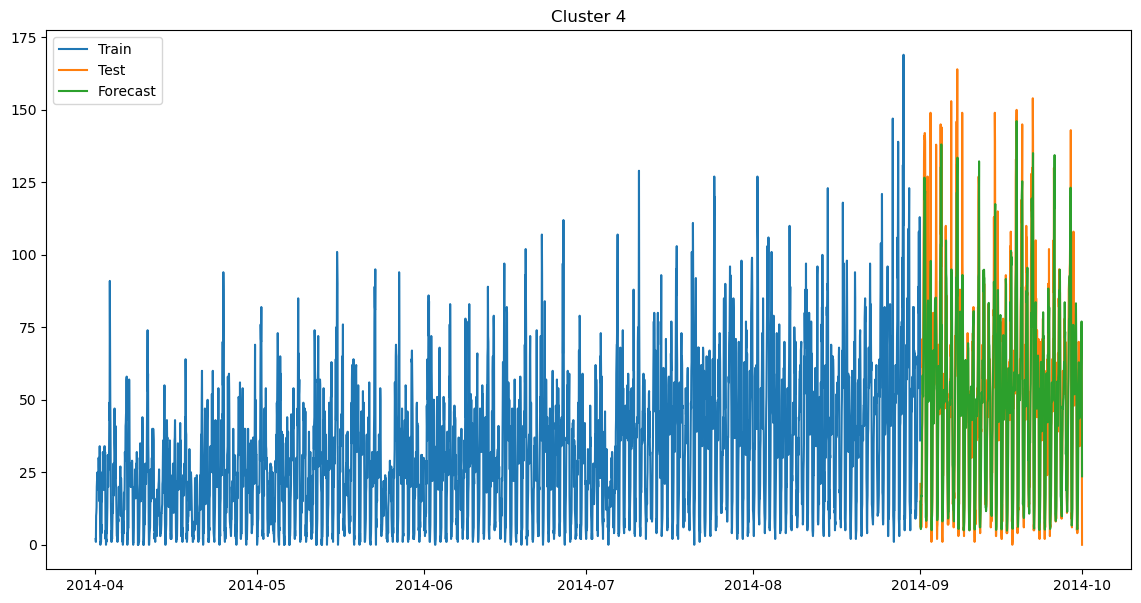

Processing cluster 5...
Cluster 5: Best number of lags: 11 with MAE: 1.5400241263003813


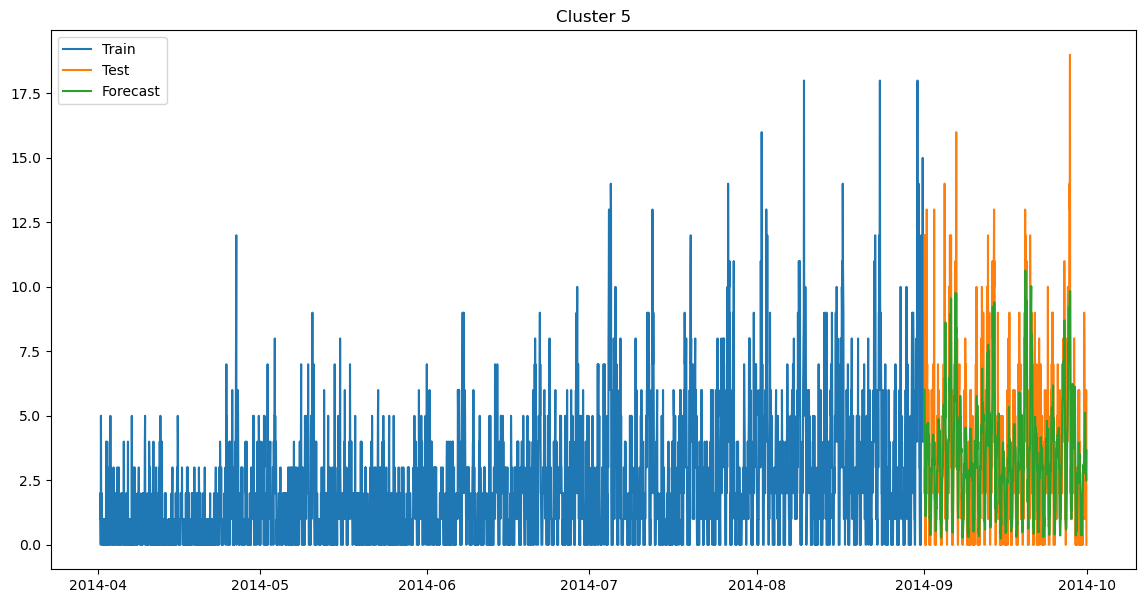

Processing cluster 6...
Cluster 6: Best number of lags: 4 with MAE: 45.91882791519165


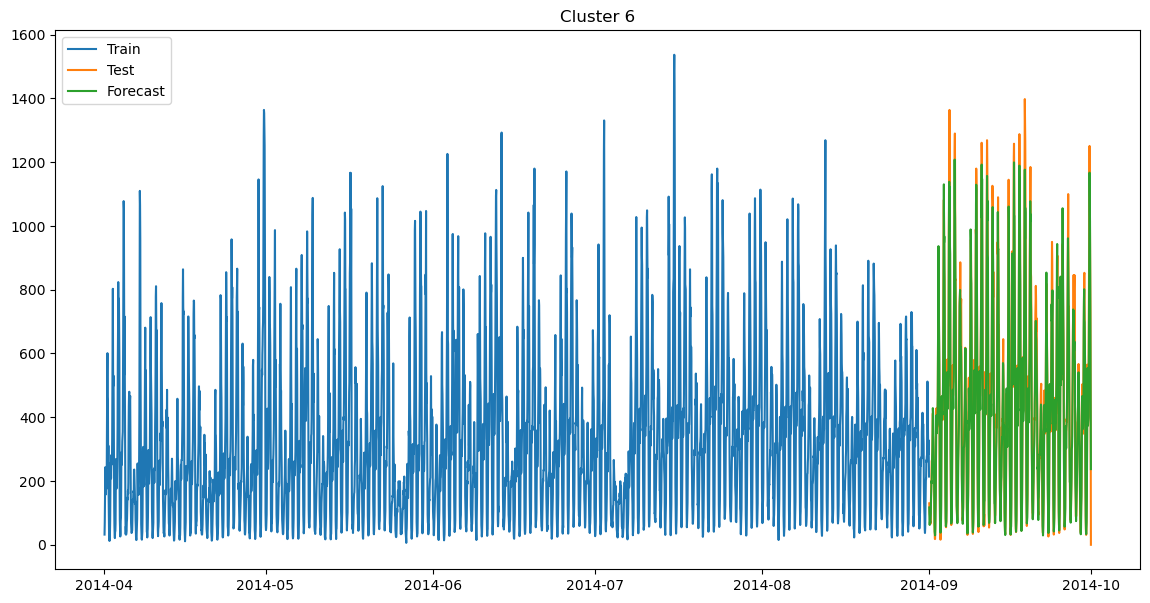

Processing cluster 7...
Cluster 7: Best number of lags: 38 with MAE: 3.5639691424038675


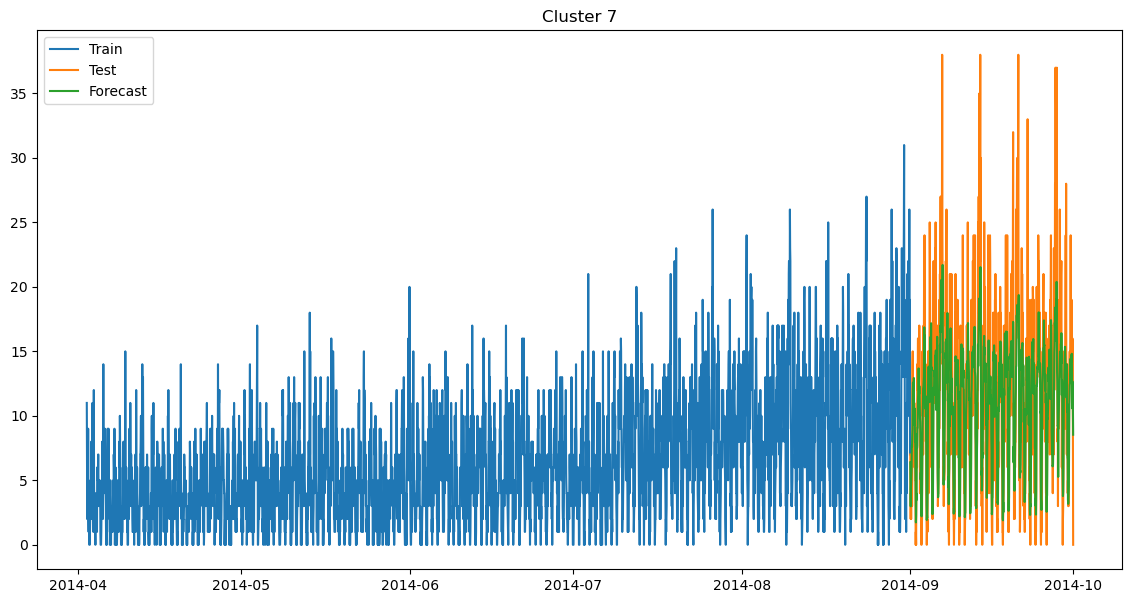

Processing cluster 8...
Cluster 8: Best number of lags: 2 with MAE: 13.730620331234402


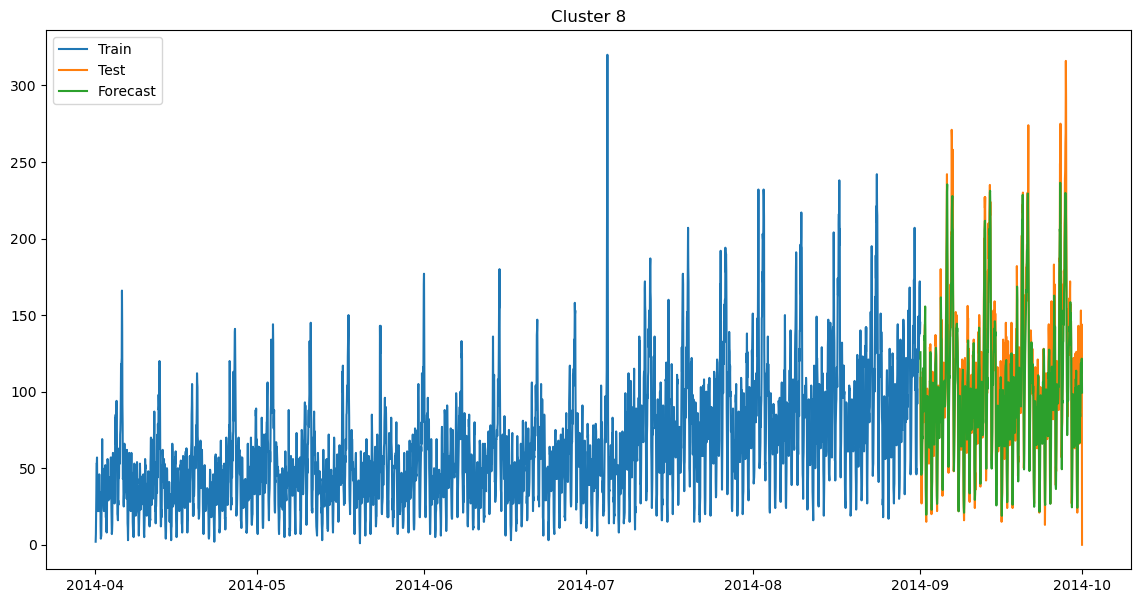

Processing cluster 9...
Cluster 9: Best number of lags: 2 with MAE: 55.44749348428514


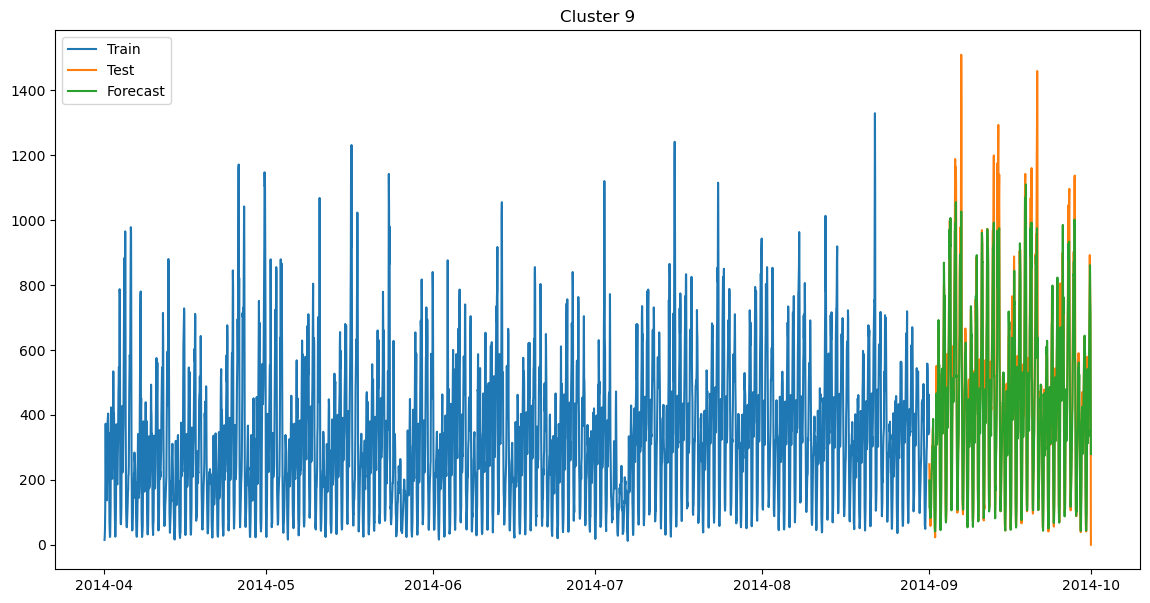

In [7]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import os

# Directory to save outputs
model_training_dir = '../Model_Training'
lag_features_dir = os.path.join(model_training_dir, 'lag_features')
plot_dir = os.path.join(model_training_dir, 'plots')
features_dir = os.path.join(model_training_dir, 'feature_columns')
xgboost_dir = os.path.join(model_training_dir, 'xgboost_models')
os.makedirs(model_training_dir, exist_ok=True)
os.makedirs(lag_features_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)
os.makedirs(xgboost_dir, exist_ok=True)

# Dictionary to store results
results = {}
lag_features = {}

# Define a function to create lag features
def create_lag_features(df, max_lag):
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['TotalPickups'].shift(lag)
    df.dropna(inplace=True)
    return df

# Define a function to evaluate the model with a given number of lags
def evaluate_model(df, max_lag):
    df = create_lag_features(df.copy(), max_lag)
    
    # Features and target
    feature_columns = ['Hour', 'DayOfWeek', 'IsWeekend', 'Month', 'Holiday_0', 'Holiday_1'] + \
                      [f'lag_{lag}' for lag in range(1, max_lag + 1)]
    
    X = df[feature_columns]
    y = df['TotalPickups']
    
    # Split data into training and testing sets
    X_train, X_test = X[:'2014-08'], X['2014-09':]
    y_train, y_test = y[:'2014-08'], y['2014-09':]
    
    # Train XGBoost model
    model = XGBRegressor(
        n_estimators=1000, learning_rate=0.01, max_depth=6, 
        subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=50
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    # Forecast the test period
    y_forecasted = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_forecasted)
    
    return model, mae, df[feature_columns + ['TotalPickups']].tail(max_lag), feature_columns, y_train, y_test, y_forecasted

# Loop through each cluster
for cluster in range(0, 10):
    print(f'Processing cluster {cluster}...')

    # Filter data for the current cluster
    df_cluster = df[df['Cluster'] == cluster].copy()

    # Grid search over the number of lags
    lag_range = range(1, 50)
    best_lag = 1
    best_error = float('inf')

    for lag in lag_range:
        model, error, lag_df, feature_columns, y_train, y_test, y_forecasted = evaluate_model(df_cluster, lag)
        if error < best_error:
            best_error = error
            best_lag = lag
            best_model = model
            best_lag_df = lag_df
            best_feature_columns = feature_columns
            best_y_train = y_train
            best_y_test = y_test
            best_y_forecasted = y_forecasted

    print(f'Cluster {cluster}: Best number of lags: {best_lag} with MAE: {best_error}')

    # Store best model and lag features
    results[cluster] = {
        'model': best_model,
        'mae': best_error
    }
    lag_features[cluster] = best_lag_df
    

    # Save the model and lag features
    model_file = os.path.join(xgboost_dir, f"xgboost_model_cluster_{cluster}.pkl")
    with open(model_file, 'wb') as f:
        pickle.dump(best_model, f)

    lag_features_file = os.path.join(lag_features_dir, f'lag_features_cluster_{cluster}.pkl')
    with open(lag_features_file, 'wb') as f:
        pickle.dump(best_lag_df, f)

    # Save feature columns used in training
    feature_columns_file = os.path.join(features_dir, f"feature_columns_cluster_{cluster}.pkl")
    with open(feature_columns_file, 'wb') as f:
        pickle.dump(best_feature_columns, f)


    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(best_y_train, label='Train')
    plt.plot(best_y_test, label='Test')
    plt.plot(best_y_test.index, best_y_forecasted, label='Forecast')
    plt.title(f'Cluster {cluster}')
    plt.legend()
    plt.savefig(os.path.join(plot_dir, f"cluster_{cluster}_plot.png"))  # Save the plot
    plt.show()
    plt.close()

### XGBoost Prediction

Processing cluster 0...
Saved forecast for cluster 0 to ../Prediction_Results/forecast_cluster_0.csv


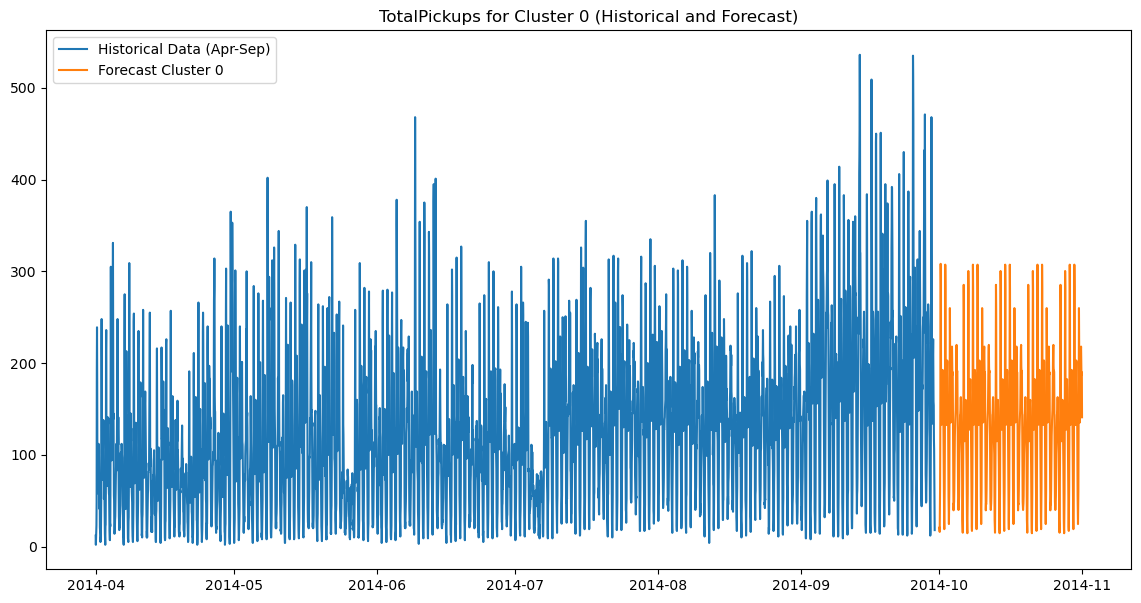

Processing cluster 1...
Saved forecast for cluster 1 to ../Prediction_Results/forecast_cluster_1.csv


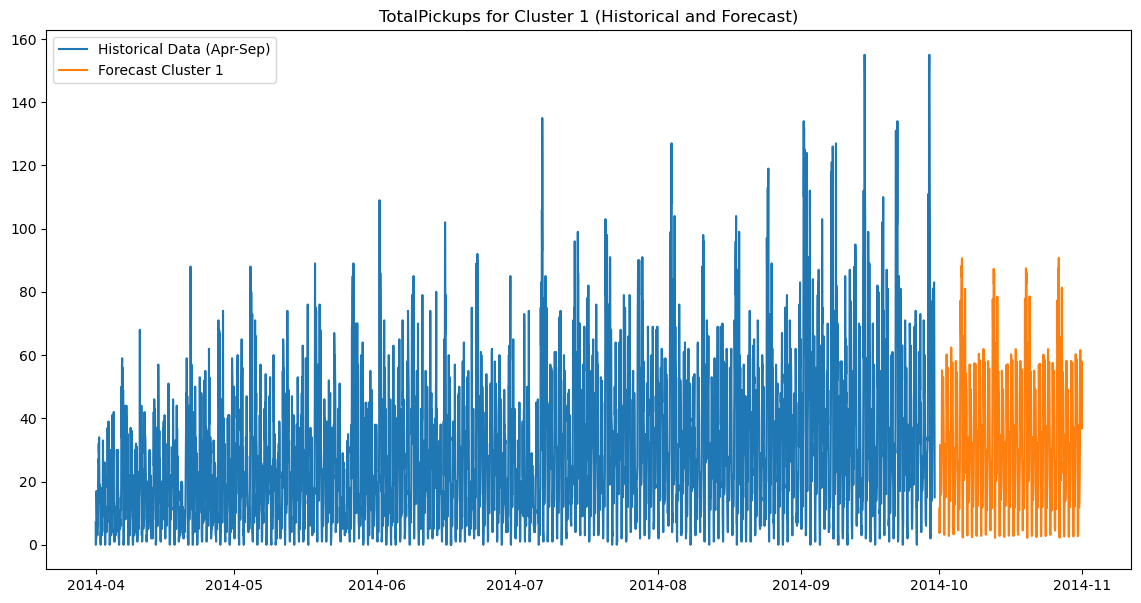

Processing cluster 2...
Saved forecast for cluster 2 to ../Prediction_Results/forecast_cluster_2.csv


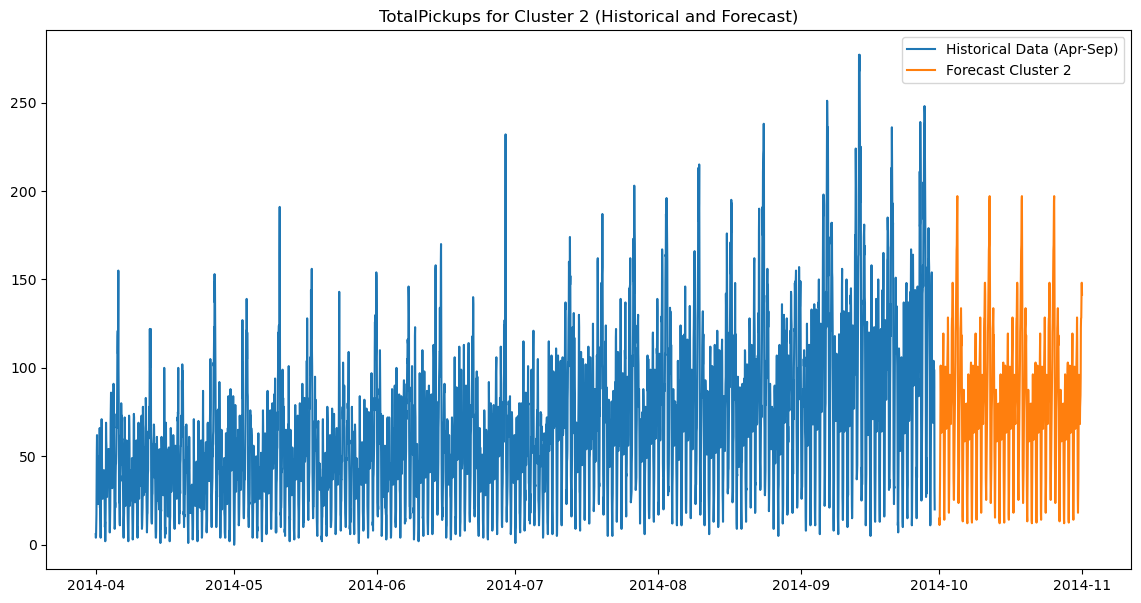

Processing cluster 3...
Saved forecast for cluster 3 to ../Prediction_Results/forecast_cluster_3.csv


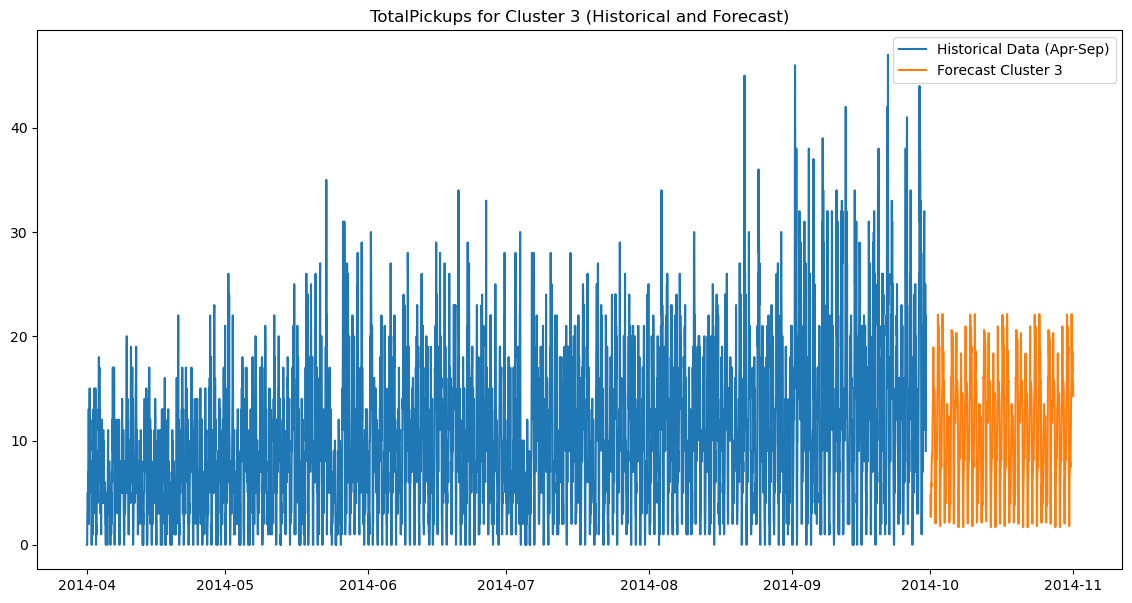

Processing cluster 4...
Saved forecast for cluster 4 to ../Prediction_Results/forecast_cluster_4.csv


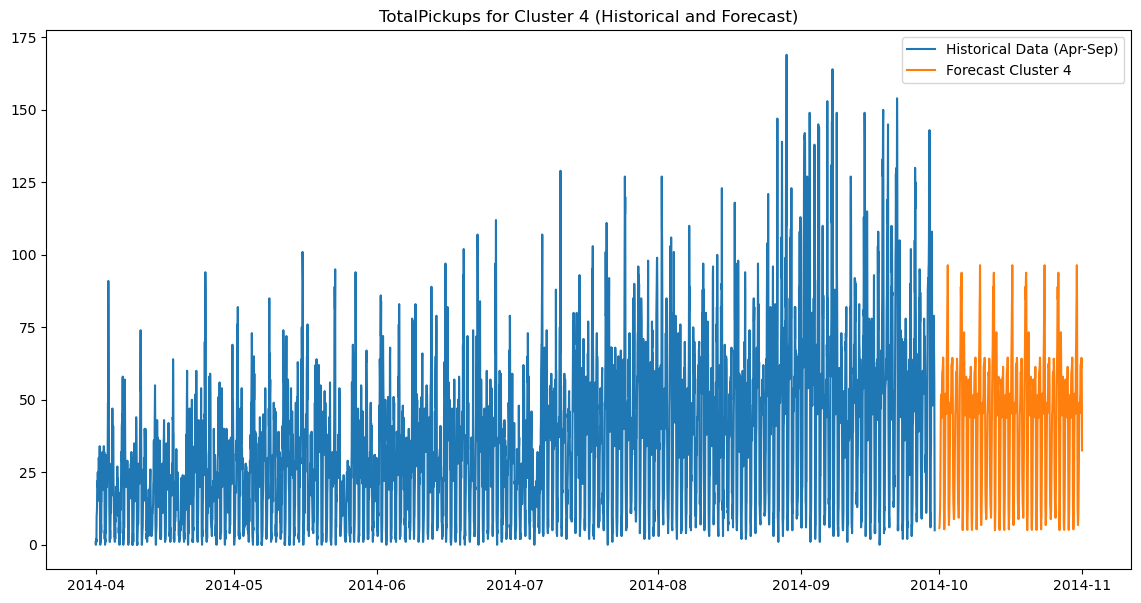

Processing cluster 5...
Saved forecast for cluster 5 to ../Prediction_Results/forecast_cluster_5.csv


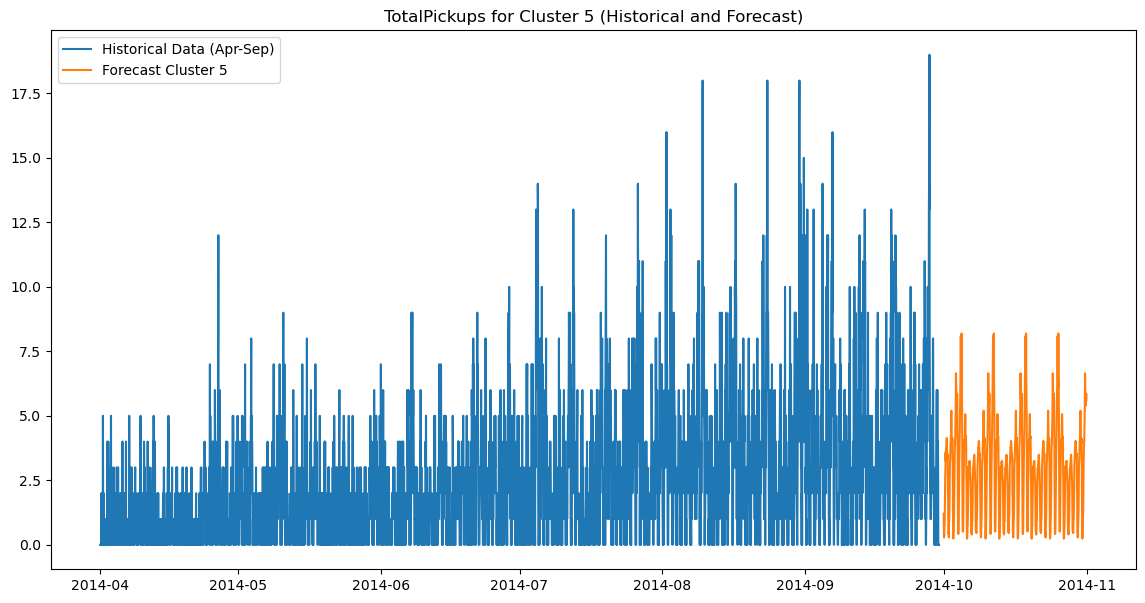

Processing cluster 6...
Saved forecast for cluster 6 to ../Prediction_Results/forecast_cluster_6.csv


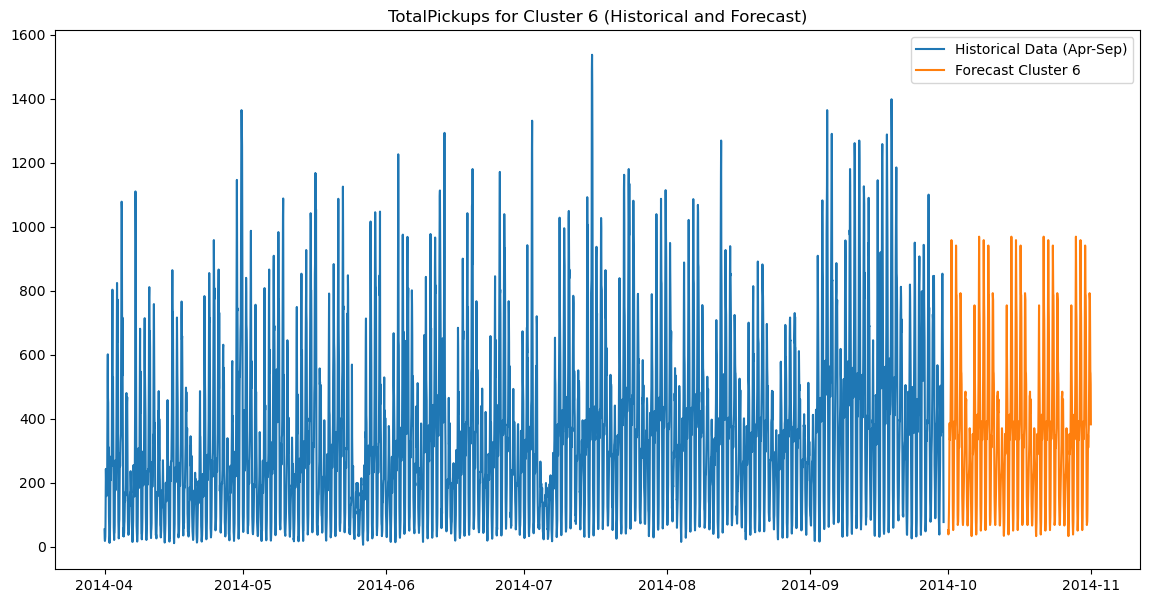

Processing cluster 7...
Saved forecast for cluster 7 to ../Prediction_Results/forecast_cluster_7.csv


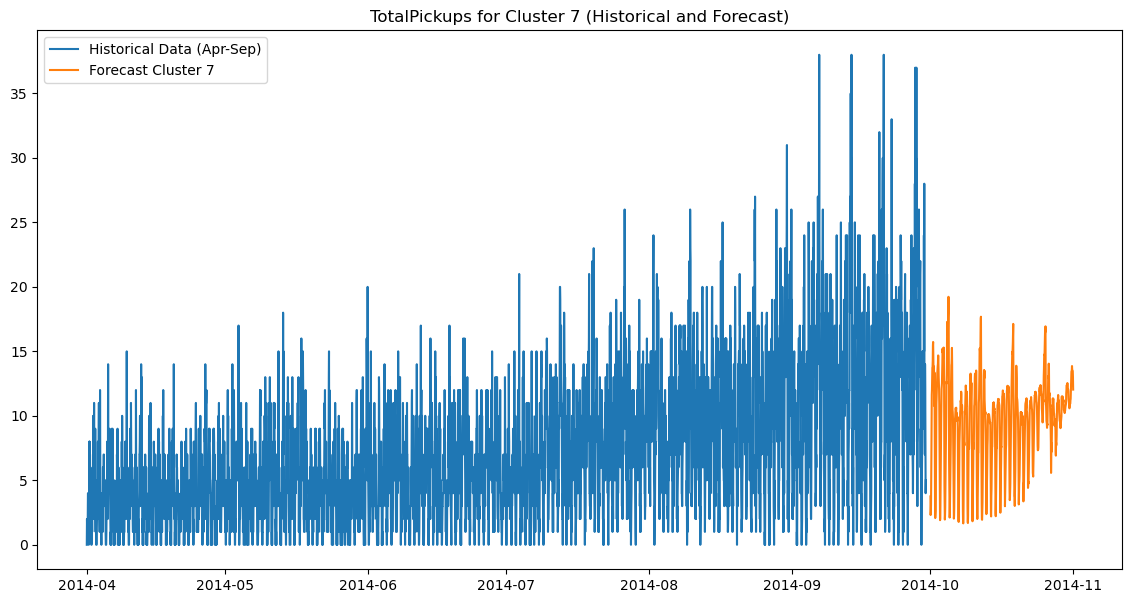

Processing cluster 8...
Saved forecast for cluster 8 to ../Prediction_Results/forecast_cluster_8.csv


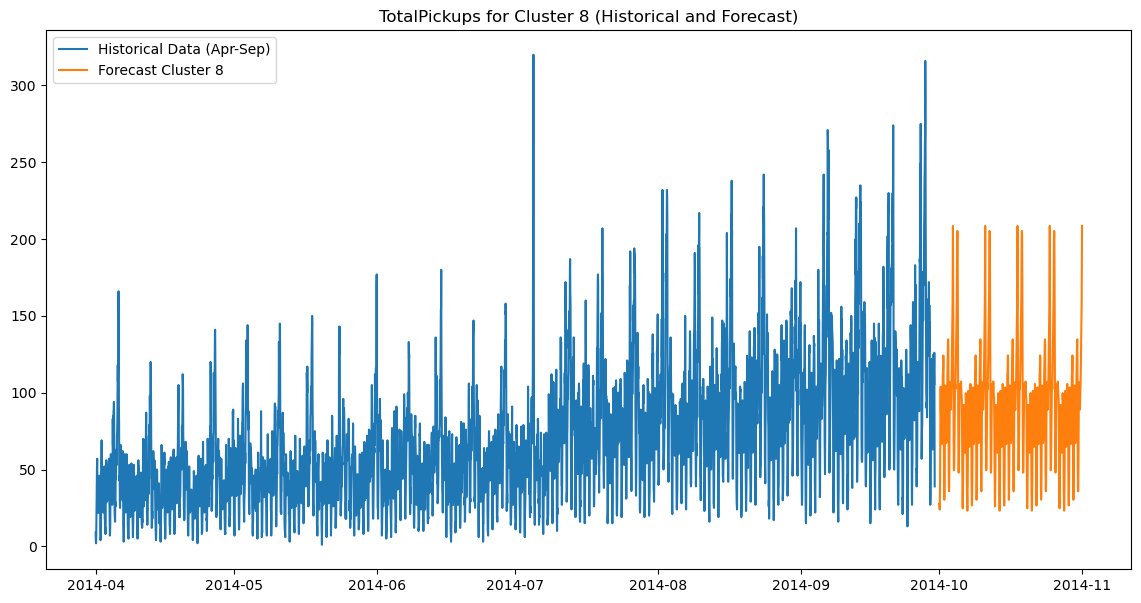

Processing cluster 9...
Saved forecast for cluster 9 to ../Prediction_Results/forecast_cluster_9.csv


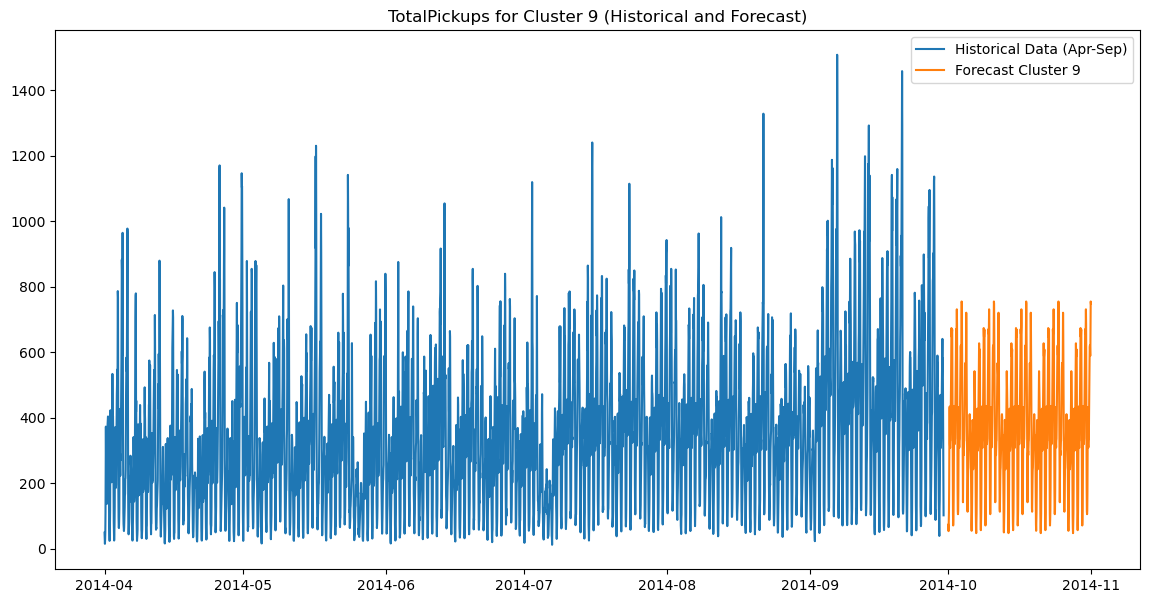

                     Cluster  Hour  Month  IsWeekend  DayOfWeek  TotalPickups  \
2014-10-01 00:00:00        0     0     10          0          2     20.612730   
2014-10-01 01:00:00        0     1     10          0          2     18.375011   
2014-10-01 02:00:00        0     2     10          0          2     16.027344   
2014-10-01 03:00:00        0     3     10          0          2     40.642433   
2014-10-01 04:00:00        0     4     10          0          2     62.818825   

                     Holiday_0  Holiday_1  
2014-10-01 00:00:00        1.0        0.0  
2014-10-01 01:00:00        1.0        0.0  
2014-10-01 02:00:00        1.0        0.0  
2014-10-01 03:00:00        1.0        0.0  
2014-10-01 04:00:00        1.0        0.0  


In [9]:
from copy import deepcopy

# DataFrame to store the final forecasted results
df_forecast = df_october.copy()

# Create directory for Prediction Results
prediction_results_dir = '../Prediction_Results'
os.makedirs(prediction_results_dir, exist_ok=True)

# Date range for historical data
historical_period = pd.date_range(start='2014-04-01', end='2014-09-30', freq='H')

# Iterate through each cluster
for cluster in range(0, 10):
    print(f'Processing cluster {cluster}...')

    # Load the XGBoost model for the current cluster
    model_file = os.path.join(xgboost_dir, f"xgboost_model_cluster_{cluster}.pkl")
    with open(model_file, 'rb') as f:
        model = pickle.load(f)

    # Load feature columns used in training
    feature_columns_file = os.path.join(features_dir, f"feature_columns_cluster_{cluster}.pkl")
    with open(feature_columns_file, 'rb') as f:
        best_feature_columns = pickle.load(f)

    # Load lag features for prediction
    lag_features_file = os.path.join(lag_features_dir, f"lag_features_cluster_{cluster}.pkl")
    with open(lag_features_file, 'rb') as f:
        lag_features = pickle.load(f)
    
    # Retrieve lag features specific to the current cluster
    lag_data = deepcopy(lag_features)

    # Filter forecast data for the current cluster
    df_october_cluster = df_october[df_october['Cluster'] == cluster].copy()

    # Ensure df_october_cluster is correctly indexed by the forecast period
    df_october_cluster.index = pd.date_range(start='2014-10-01 00:00:00', end='2014-10-31 23:00:00', freq='H')

    # Ensure df_october_cluster has all the required feature columns, including lags
    missing_cols = set(best_feature_columns) - set(df_october_cluster.columns)
    for col in missing_cols:
        df_october_cluster[col] = np.nan

    # Iterate over each date in the forecast period for the current cluster
    for date in df_october_cluster.index:
        # Prepare the features for the current date
        X = pd.DataFrame(index=[date], columns=best_feature_columns)

        # Fill in the known features
        for col in ['Hour', 'DayOfWeek', 'IsWeekend', 'Month', 'Holiday_0', 'Holiday_1']:
            X[col] = df_october_cluster.at[date, col]

        # Update the lag features in X with values from lag_data
        for lag in range(1, len([col for col in best_feature_columns if col.startswith('lag_')]) + 1):
            lag_date = date - pd.DateOffset(hours=lag)
            lag_value = lag_data.at[lag_date, 'TotalPickups'] if lag_date in lag_data.index else 0
            X[f'lag_{lag}'] = lag_value

        # Ensure X contains the expected columns
        X = X[best_feature_columns]

        # Fill NaNs in X with 0s 
        X.fillna(0, inplace=True)

        # Predict the TotalPickups for the current date using the XGBoost model
        y_pred = model.predict(X)[0]
        df_october_cluster.at[date, 'TotalPickups'] = y_pred

        # Update lag_data with the new prediction
        new_lag_row = df_october_cluster.loc[date, best_feature_columns + ['TotalPickups']].to_frame().T
        lag_data = pd.concat([lag_data, new_lag_row])

    # Save updated lag features for the cluster
    new_lag_features_file = os.path.join(lag_features_dir, f'lag_features_cluster_{cluster}.pkl')
    with open(new_lag_features_file, 'wb') as f:
        pickle.dump(lag_data, f)

    # Save the forecasted values to df_forecast
    df_forecast.loc[df_forecast['Cluster'] == cluster, 'TotalPickups'] = df_october_cluster['TotalPickups']
    
    # Save the forecasted values to a CSV file
    forecast_csv_file = os.path.join(prediction_results_dir, f"forecast_cluster_{cluster}.csv")
    df_october_cluster.to_csv(forecast_csv_file)
    print(f"Saved forecast for cluster {cluster} to {forecast_csv_file}")

    # Incorporate historical data for the current cluster
    historical_data_cluster = df[(df['Cluster'] == cluster) & (df.index.isin(historical_period))]

    plt.figure(figsize=(14, 7))
    # Plot historical data
    plt.plot(historical_data_cluster.index, historical_data_cluster['TotalPickups'], label='Historical Data (Apr-Sep)')
    
    # Plot forecasted data
    plt.plot(df_october_cluster.index, df_october_cluster['TotalPickups'], label=f'Forecast Cluster {cluster}')
    plt.title(f'TotalPickups for Cluster {cluster} (Historical and Forecast)')
    plt.legend()
    plt.show()
    plt.close()

# Display the final forecast DataFrame
print(df_forecast.head())